# Time domain EM casing response

This notebook simulates the response of a conductive, permeable casing in a time-domain EM experiment. 

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
from multiprocessing import Pool
import pickle 
import os

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [5]:
# path_to_data = "/t40array/lheagy/casing-permeability-reproduce"
path_to_data = "./tmp"

In [6]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [7]:
run_simulations = True
directory = f"{path_to_data}/fields_permeability"

if run_simulations is True: 
    if not os.path.exists(directory):
        os.makedirs(directory)

In [9]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 500

In [10]:
# diffusion distance
1260 * np.sqrt(1/sigma_back)

3984.469851812158

In [11]:
return_electrode_r = 500
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0, 0.]

In [12]:
csz = 5
nabove = 3
npadz = 19
pf = 1.35

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=17,
    csx2=10,
    domain_x=return_electrode_r,
    pfx2=pf
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz+nabove), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz-nabove].sum()])
print(mesh.n_cells)

203040


/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/mesh.py:46: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  hx1a = utils.meshTensor([(csx1, ncx1)])
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/mesh.py:49: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  hx1b = utils.meshTensor([(csx1, npadx1, pfx1)])
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/mesh.py:58: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  hx2a = utils.meshTensor([(csx2, ncx2)])
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/mesh.py:61: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  hx2b = utils.meshTensor([(csx2, npadx, pfx2)

In [13]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    (1e-4, nt), (3e-4, nt), 
    (1e-3, nt*2), (3e-3, nt*2+16),
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max()*1e3)

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back)):1.0f} m")

301.3200000000002
diffusion distance 2190 m


PolarAxesSubplot


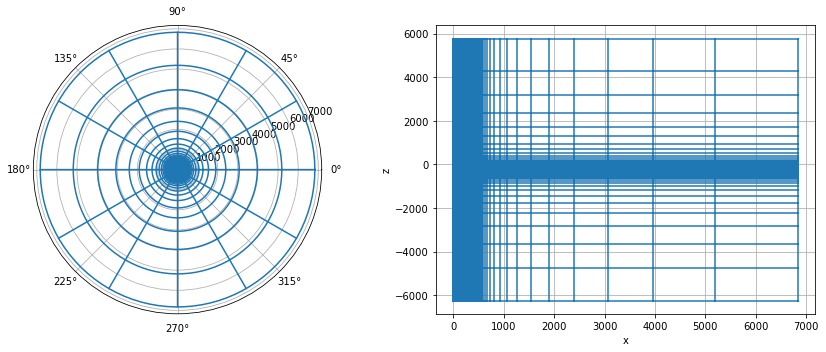

In [14]:
ax = mesh.plot_grid()

In [15]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
inds_casing = inds_casing_x & inds_casing_z

In [16]:
mur_casing

array([  1,  50, 100, 150, 200])

In [17]:
halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

casing_conductivity = halfspace_conductivity.copy()
casing_conductivity[inds_casing] = sigma_casing

models = {}

models["halfspace"] = {
    "sigma": halfspace_conductivity, 
    "mur": np.ones(mesh.n_cells)
} 

for mur in mur_casing:
    key = f"casing_{mur:1.0f}"
    casing_mur = np.ones(mesh.n_cells)
    casing_mur[inds_casing] = mur
    # casing_permeability = casing_mur
    models[key] = {
        "sigma": casing_conductivity, 
        "mur": casing_mur
    }

# for mur in [200, sigma_casing]:
#     key = f"permeable_only_{mur:1.0f}"
#     casing_mur = np.ones(mesh.n_cells)
#     casing_mur[inds_casing] = mur
#     casing_permeability = casing_mur
#     models[key] = {
#         "sigma": halfspace_conductivity, 
#         "mur": casing_permeability
#     }
    

In [18]:
def plot_casing(ax): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, casing_conductivity, pcolor_opts=pcolor_opts, ax=ax,
    )
    out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
    ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
    ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
    for sign in np.r_[-1, 1]: 
        ax.arrow(
            0, -casing_l+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )

        ax.arrow(
            0, -casing_l-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )
    ax.text(0, -casing_l+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
    ax.text(0, -casing_l-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [19]:
def plot_geometry(ax):
    survey_lim = (return_electrode_r + 70) * np.r_[-1, 1]
    norm = LogNorm(vmin=sigma_air, vmax=sigma_casing)
    cmap = colormap.get_cmap("Spectral_r")
    ax.set_facecolor(cmap(norm(sigma_back)))

    ax.plot(np.r_[0, return_electrode_r], np.r_[0, 0], color="k", marker="v")
    ax.plot(np.r_[0, 0], np.r_[0, survey_lim.max()], color="k", ls=":")
    ax.plot(0, 0, "o", color=cmap(norm(sigma_casing)), ms=8)

    ax.text(return_electrode_r/2, 10, "transmitter", ha="center")
    ax.text(0, -75, "casing", ha="center")
    ax.text(-5, survey_lim.max()/2, "receivers", ha="right")

    ax.set_xlim(survey_lim)
    ax.set_ylim(survey_lim)
    ax.set_aspect(1)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    return ax


In [20]:
from matplotlib import rcParams
rcParams["font.size"] = 16

/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/utils.py:94: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  [mesh.hx, 1., mesh.hz], x0=mesh.x0
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/utils.py:94: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  [mesh.hx, 1., mesh.hz], x0=mesh.x0
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/utils.py:93: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  mesh2D = CylMesh(
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/view.py:57: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  if not mesh.isSymmetric:
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/view.py:63: FutureWarning: CylMesh.plotImage has been deprecated, please

Text(0.5, 1.0, '(b)')

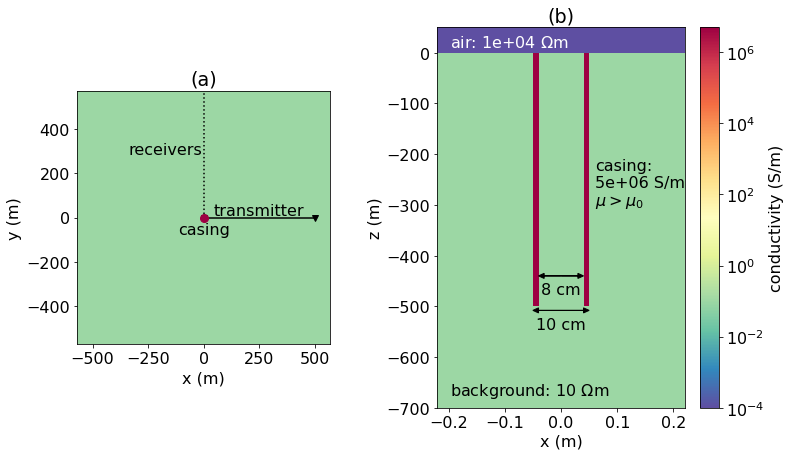

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 1.22], "wspace":0.38})

plot_geometry(ax[0])
plot_casing(ax[1])

ax[0].set_title("(a)")
ax[1].set_title("(b)")


# if save_figures:
#     fig.savefig(f"{fig_dir_high}/setup.png", dpi=dpi_high)
#     fig.savefig(f"{fig_dir_low}/setup.png", dpi=dpi_low)


## set up the simulations

In [22]:
# top casing source 
src_theta = mesh.h[1][0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]
src_b = np.r_[return_electrode_r, src_theta, -csz/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)
src_locations

/tmp/ipykernel_42894/662256716.py:3: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]


array([[ 4.87500000e-02,  2.61799388e-01, -2.50000000e+00],
       [ 4.87500000e-02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01, -2.50000000e+00]])

In [23]:
def generate_simulation(mur=1): 
    src = tdem.sources.LineCurrent([], location=src_locations)
    survey = tdem.Survey([src])
    sim = tdem.simulation.Simulation3DMagneticField(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, time_steps=time_steps, 
        mu=mur*mu_0
    #     verbose=True
    )
    return sim


In [24]:
def load_fields(name, conductivity, mur):
    solution = np.load(f"{directory}/fields_{name}.npy")
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, sim._fieldType + "Solution", :] = solution
    return f

In [25]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/times", times)
    
    with open(f"{directory}/models.pkl", "wb") as fp:
        pickle.dump(models, fp)

In [26]:
def run_simulation(key):
    t = time.time()
    print(f"starting {key}\n")
    sim = generate_simulation(models[key]["mur"])
    f = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_{key}", f[:, f"{sim._fieldType}Solution", :])
    print(f" ... done {key}. {time.time()-t:1.2e} s")

In [27]:
models["casing_1"]["sigma"].min()

0.0001

In [28]:
if run_simulations:   
    # runs on 6 processors in parallel
    with Pool(6) as p:
        p.map(run_simulation, list(models.keys()))  
        
    # if you prefer to run in series, comment out the above and uncomment the code below
    # for key in models.keys():
    #     run_simulation(key)

starting casing_150
starting casing_50
starting casing_1
starting casing_100
starting halfspace
starting casing_200








/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, 

 ... done halfspace. 7.32e+02 s
 ... done casing_150. 7.47e+02 s
 ... done casing_200. 7.47e+02 s
 ... done casing_50. 7.81e+02 s
 ... done casing_100. 7.89e+02 s
 ... done casing_1. 7.91e+02 s


In [29]:
fields={}
for key in models.keys(): 
    fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])


In [30]:
# casing_permeability_mu_only = [200, int(sigma_casing)]
# keys_permeable_only = [f"permeable_only_{mur}" for mur in casing_permeability_mu_only]
# for key, mur in zip(keys_permeable_only, casing_permeability_mu_only):
#     fields[key] = run_simulation(key, mur)

In [31]:
# for key, mur in zip(keys_permeable_only, casing_permeability_mu_only):
#     casing_mur = np.ones(mesh.n_cells)
#     casing_mur[inds_casing] = mur
#     mu = mu_0 * casing_mur
#     fields[key] = load_fields(key, halfspace_conductivity, mu)

In [32]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    # 137,
    152,
    169,
    197,
    # 207,
    # 212,
    # 227,
    249,
    # 282,
] 
print(times[time_inds] * 1e3)

[0.0000e+00 9.9000e-02 9.9000e-01 4.9200e+00 1.0020e+01 3.0320e+01
 1.0032e+02]


/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/view.py:350: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  if mesh.isSymmetric:
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/view.py:360: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  if not mesh.isSymmetric:
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/utils.py:38: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  if mesh3D.isSymmetric:
/home/lheagy/git/simpeg-research/casingSimulations/casingSimulations/view.py:129: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0 of discr

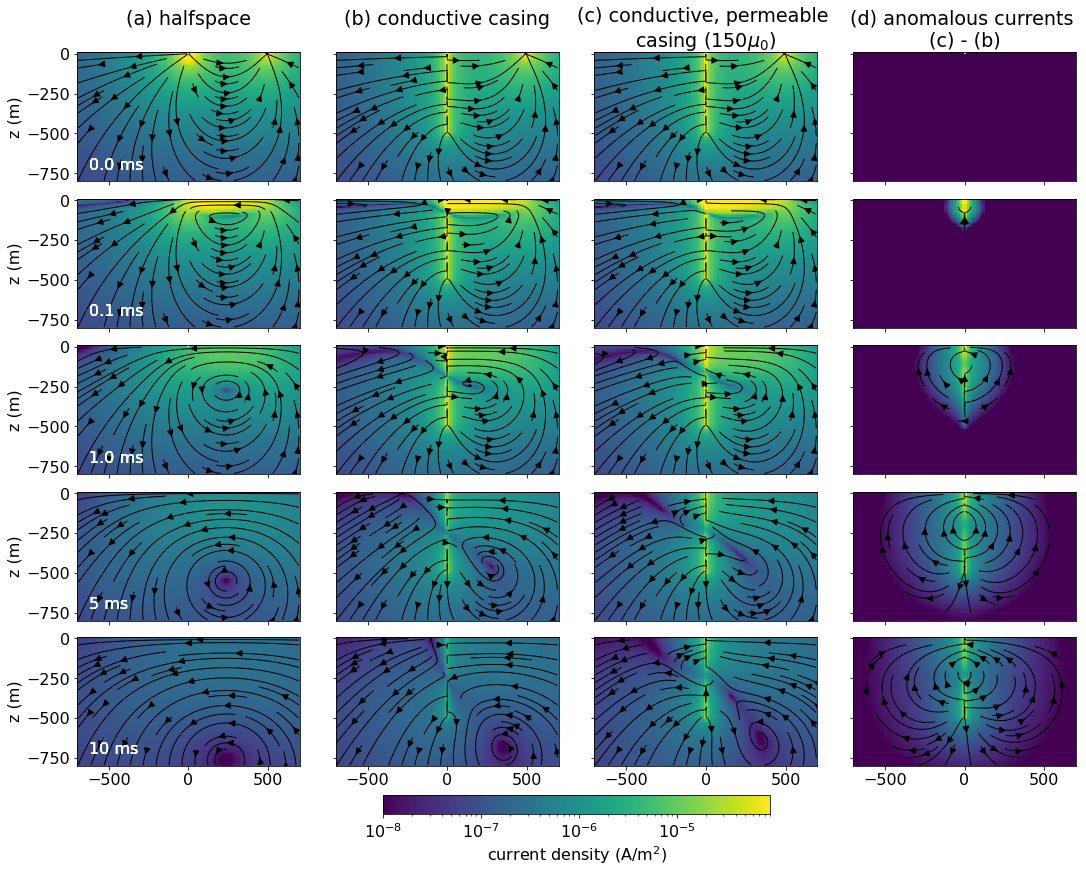

In [33]:
fig, ax = plt.subplots(
    len(time_inds)-2, 4, 
    figsize=(15, (len(time_inds)-2)*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=700 * np.r_[-1, 1]
zlim=np.r_[-800, 10]
clim = np.r_[1e-8, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}

primary_key = "casing_1"
plot_keys = ["halfspace", "casing_1", "casing_150"]
for j, key in enumerate(plot_keys):
    f = fields[key]
    
    if key == plot_keys[-1]:
        primsec = ["total", "secondary"]
    else:
        primsec = ["total"]
    
    for i, ti in enumerate(time_inds[:-2]):
        for k, ps in enumerate(primsec): 
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                time_ind=ti,
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i,j+k], 
                clim=clim,
                show_cb=False,
                prim_sec=ps,
                primary_fields=fields[primary_key],
                stream_opts=stream_opts
            )
            ax[i, j+k].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, j+k].set_title("")
            if times[ti] < 2e-3: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
            else: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
            if i < len(time_inds)-1:
                ax[i, j+k].set_xlabel("")
            else:
                ax[i, j+k].set_xlabel("x (m)")
            if j > 0: 
                ax[i, j+k].set_ylabel("")
            else:
                ax[i, j+k].set_ylabel("z (m)")
            ax[i, j+k].set_aspect(1)
    
ax[0, 0].set_title("(a) halfspace\n")
ax[0, 1].set_title("(b) conductive casing\n")
ax[0, 2].set_title("(c) conductive, permeable \ncasing (150$\mu_0$)")
ax[0, 3].set_title("(d) anomalous currents \n(c) - (b)")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

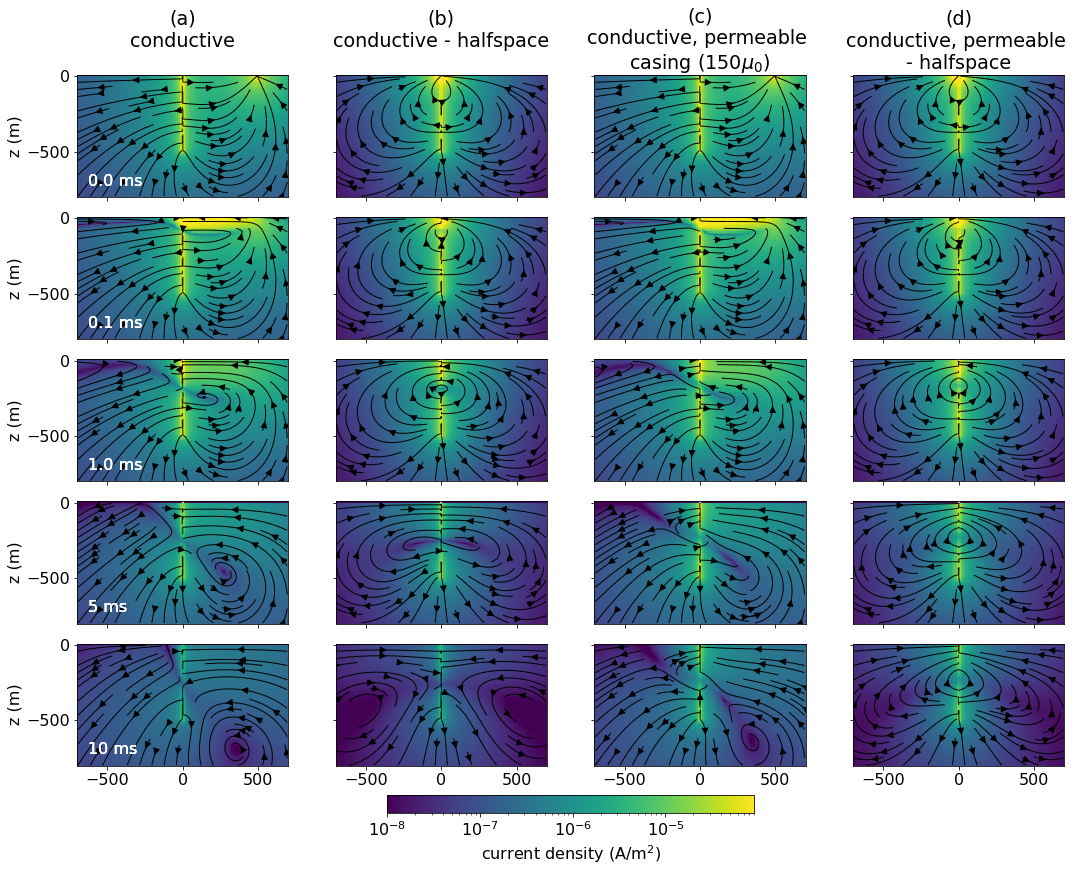

In [34]:
fig, ax = plt.subplots(
    len(time_inds)-2, 4, 
    figsize=(15, (len(time_inds)-2)*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=700 * np.r_[-1, 1]
zlim=np.r_[-800, 10]
clim = np.r_[1e-8, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}

primary_key = "halfspace"
plot_keys = ["casing_1", "casing_150"]
jj = 0
for j, key in enumerate(plot_keys):
    f = fields[key]
    primsec = ["total", "secondary"]
    
    
    for k, ps in enumerate(primsec): 
        for i, ti in enumerate(time_inds[:-2]):
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                time_ind=ti,
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i,jj], 
                clim=clim,
                show_cb=False,
                prim_sec=ps,
                primary_fields=fields[primary_key],
                stream_opts=stream_opts
            )
            ax[i, jj].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, jj].set_title("")
            if times[ti] < 2e-3: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
            else: 
                ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
            if i < len(time_inds)-1:
                ax[i, jj].set_xlabel("")
            else:
                ax[i, jj].set_xlabel("x (m)")
            if jj > 0: 
                ax[i, jj].set_ylabel("")
            else:
                ax[i, jj].set_ylabel("z (m)")
            ax[i, jj].set_aspect(1)
        jj+=1
    
ax[0, 0].set_title("(a)\nconductive\n")
ax[0, 1].set_title("(b)\nconductive - halfspace\n")
ax[0, 2].set_title("(c)\nconductive, permeable \ncasing (150$\mu_0$)")
ax[0, 3].set_title("(d)\nconductive, permeable \n- halfspace")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

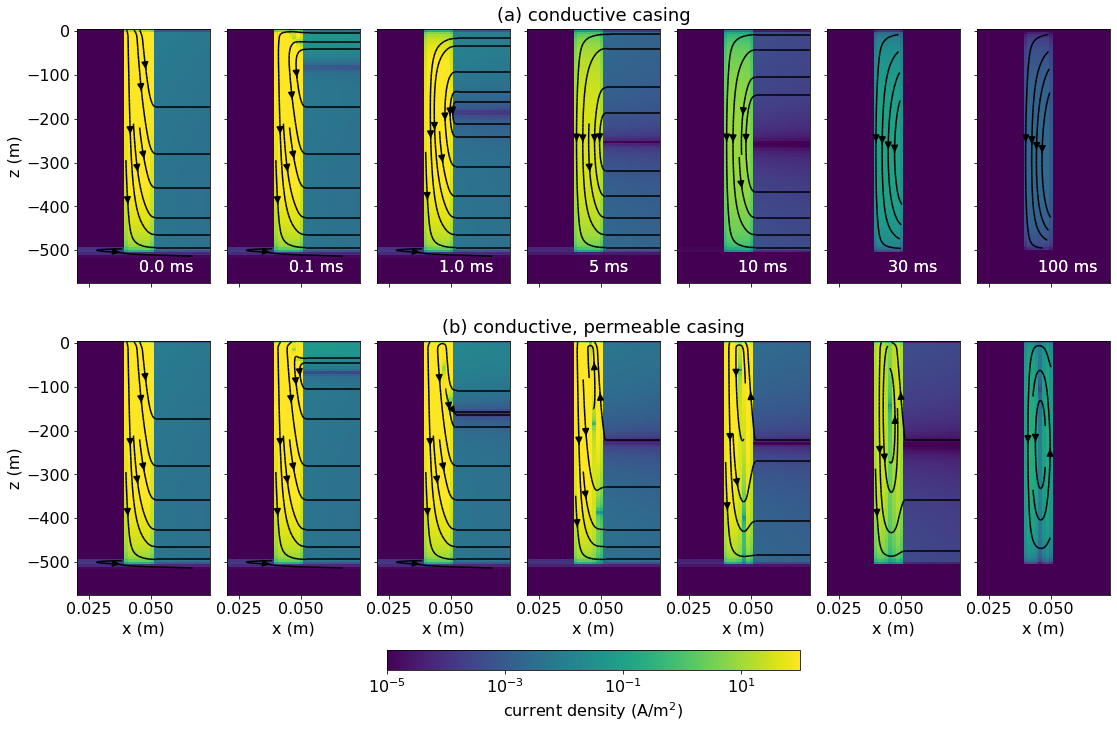

In [36]:
fig, ax = plt.subplots(
    2, len(time_inds),
    figsize=(len(time_inds)*2.2, 10),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.02}
)

xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-5, 1e2]

stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(["casing_1", "casing_150"]):
    f = fields[key]
    
    for j, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        
        if times[ti] < 2e-3: 
            ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
        else: 
            ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)
        
        if i == 0:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.074])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")

ax[0, 3].set_title("(a) conductive casing", fontsize=18, pad=8)
ax[1, 3].set_title("(b) conductive, permeable casing", fontsize=18, pad=8)

if save_figures: 
    fig.savefig(f"{fig_dir_high}/tdem-casing-currents", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/tdem-casing-currents", dpi=dpi_low, bbox_inches="tight")

In [37]:
fields.keys()

dict_keys(['halfspace', 'casing_1', 'casing_50', 'casing_100', 'casing_150', 'casing_200'])

In [38]:
Icc = {}

for key, val in fields.items():
    print(key)
    Icc[key] = mesh.average_face_to_cell_vector * (
        discretize.utils.sdiag(mesh.area) * val[:, "j", :]
    )

halfspace


/tmp/ipykernel_42894/1116576827.py:6: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  discretize.utils.sdiag(mesh.area) * val[:, "j", :]


casing_1
casing_50
casing_100
casing_150
casing_200


In [39]:
Icc_cart = {}

for key, val in Icc.items():
    print(key)
    Icc_cart[key] = np.stack([
        discretize.utils.cylindrical_to_cartesian(
            mesh.gridCC, val[:, i]
        )
        for i in range(val.shape[-1])
    ], axis=-1)

halfspace
casing_1
casing_50
casing_100
casing_150
casing_200


In [40]:
Icc_cart["halfspace"].shape

(203040, 3, 317)

In [41]:
test_x = np.r_[50, 100]
test_x_inds = (mesh.gridCC[:, 0] > test_x.min()) & (mesh.gridCC[:, 0] < test_x.max())

test_theta = np.r_[0, 3, 6]
test_theta_inds = [
    (mesh.gridCC[:, 1] == mesh.cell_centers_y[i]) for i in test_theta
]

test_depths = [np.r_[75, 125], np.r_[225, 275], np.r_[375, 425]]
test_z_inds = [
    (mesh.gridCC[:, 2] > -d.max()) & (mesh.gridCC[:, 2] < -d.min())
    for d in test_depths
]

In [42]:
key = "halfspace"
thetai = test_theta_inds[0]
depthi = test_z_inds[0]
inds = test_x_inds & thetai & depthi
Icc_cart["halfspace"][inds, :, :].sum(0).shape

(3, 317)

In [43]:
e_avg = {}
for key, val in Icc_cart.items():
    tmp = np.zeros((len(test_theta_inds), len(test_z_inds), len(times)))
    for i, thetai in enumerate(test_theta_inds):
        for j, depthi in enumerate(test_z_inds): 
            inds = test_x_inds & thetai & depthi
            Icc_total = (
                (Icc_cart[key])[inds, :, :].sum(0)
            )
            Icc_amplitude = np.sqrt((Icc_total**2).sum(0))
            Ecc = (Icc_amplitude / mesh.vol[inds].sum()) / sigma_back
            tmp[i, j, :] = Ecc
    e_avg[key] = tmp
            

/tmp/ipykernel_42894/2420729013.py:11: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  Ecc = (Icc_amplitude / mesh.vol[inds].sum()) / sigma_back


In [44]:
e_avg["casing_1"].shape

(3, 3, 317)

In [45]:
dt = np.diff(times)
eij = e_avg["casing_1"][0, 0, :]
eint = np.cumsum(np.hstack([np.r_[eij[0]], (eij[:-1] + eij[1:])/2 * dt]))
eint.shape

(317,)

In [46]:
e_integrated = {}
for key, val in e_avg.items():
    tmp = np.zeros((len(test_theta_inds), len(test_z_inds), len(times)))
    for i, thetai in enumerate(test_theta_inds):
        for j, depthi in enumerate(test_z_inds): 
            eij = val[i, j, :]
            tmp[i, j] = np.cumsum(np.hstack([np.r_[0], (eij[:-1] + eij[1:])/2 * dt]))
    e_integrated[key] = tmp

/tmp/ipykernel_42894/1304697481.py:11: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  f"$\\theta$={(mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi:1.0f}$^\circ$, depth={np.mean(depthi):1.0f}m"


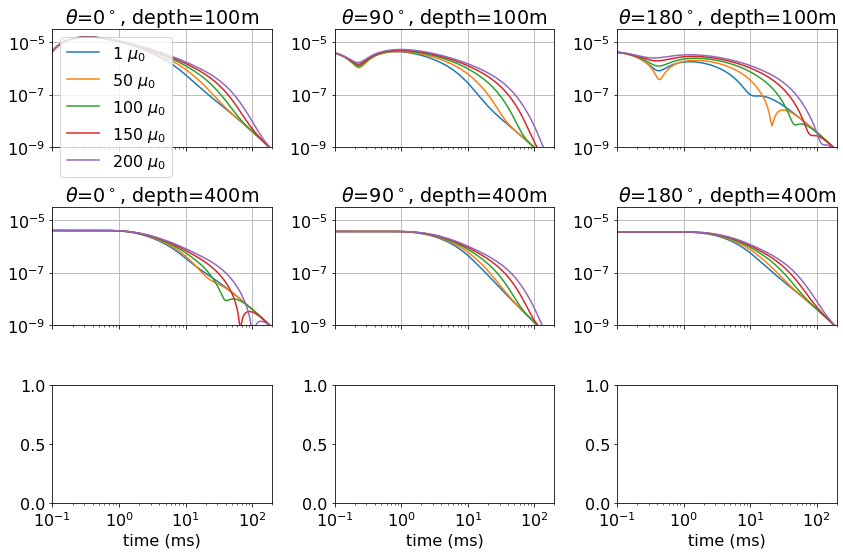

In [47]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=False)
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            ax[j, i].loglog(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i].set_title(
                f"$\\theta$={(mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi:1.0f}$^\circ$, depth={np.mean(depthi):1.0f}m"
            )
            ax[j, i].grid("both")
            ax[j, i].set_xlim([1e-1, 2e2])
            ax[j, i].set_ylim([1e-9, 3e-5])

for a in ax[2, :].flatten():
    a.set_xlabel("time (ms)")
    
ax[0, 0].legend()

plt.tight_layout()
            

/tmp/ipykernel_42894/2275587421.py:10: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi


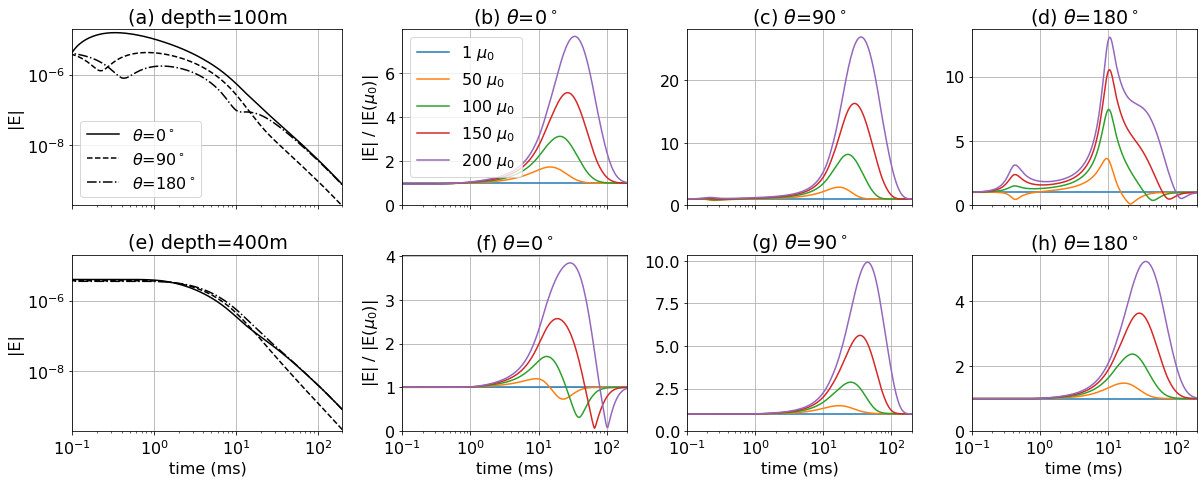

In [48]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(2, 4, figsize=(17, 7), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1.2, 1, 1, 1]})

primary_key = "casing_1"
linestyles = ["-", "--", "-."]
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key] / e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            
            if key in primary_key:
                ax[j, 0].loglog(
                    times*1e3, e_avg[key][i, jj, :], color="k", 
                    ls=linestyles[i], label=f"$\\theta$={theta_label:1.0f}$^\circ$"
                )
                ax[j, 0].set_title(f"({ascii_lowercase[j*4]}) depth={np.mean(depthi):1.0f}m")
            ax[j, i+1].semilogx(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i+1].set_title(
                f"({ascii_lowercase[(j*4+1)+i]}) $\\theta$={theta_label:1.0f}$^\circ$"
            )
                    
for a in ax.flatten():              
    a.grid("both")
            
ax[0, 0].set_xlim([1e-1, 2e2])
# ax[0, 0].set_ylim([0, 25])

for a in ax[-1, :].flatten():
    a.set_xlabel("time (ms)")

for a in ax[:, 0]:
    a.set_ylim([2e-10, 2e-5])
    a.set_ylabel("|E|")

for a in ax[:, 1]:
    a.set_ylabel("|E| / |E($\mu_0$)|")

for a in ax[:, 1:].flatten():
    tmp = a.get_ylim()
    a.set_ylim([0, tmp[1]])

ax[0, 1].legend()
ax[0, 0].legend()

plt.tight_layout()
            
# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/excitation-time", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/excitation-time", dpi=dpi_low, bbox_inches="tight")

/tmp/ipykernel_42894/1017431774.py:11: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi


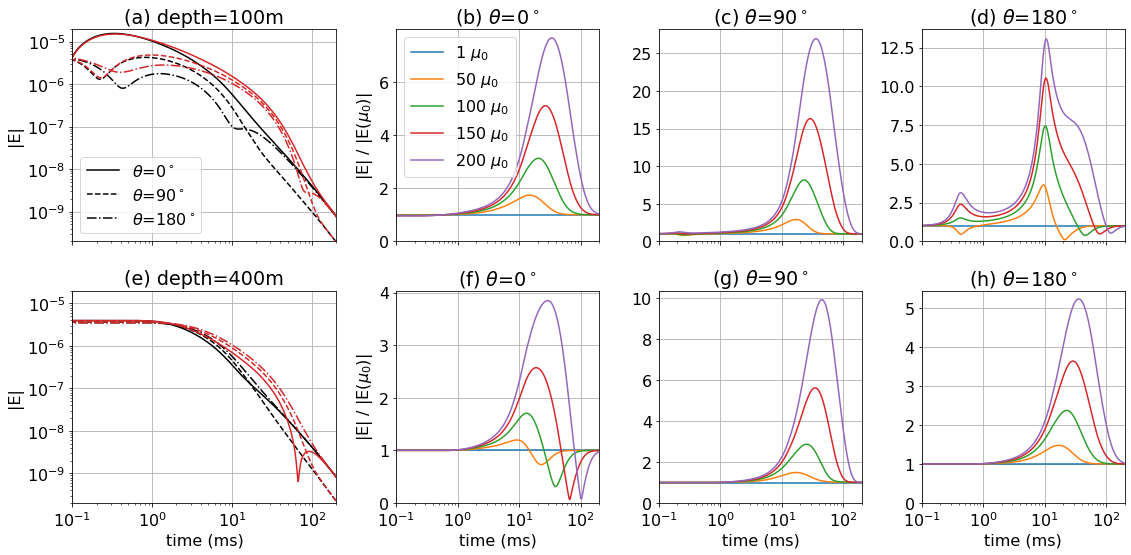

In [49]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1.3, 1, 1, 1]})

primary_key = "casing_1"
focus_key = "casing_150"
linestyles = ["-", "--", "-."]
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key] / e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            
            if key == primary_key or key == focus_key:
                ax[j, 0].loglog(
                    times*1e3, e_avg[key][i, jj, :], color="k" if key==primary_key else f"C{k}", 
                    ls=linestyles[i], label=f"$\\theta$={theta_label:1.0f}$^\circ$" if key==primary_key else None
                )
                ax[j, 0].set_title(f"({ascii_lowercase[j*4]}) depth={np.mean(depthi):1.0f}m")
            ax[j, i+1].semilogx(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i+1].set_title(
                f"({ascii_lowercase[(j*4+1)+i]}) $\\theta$={theta_label:1.0f}$^\circ$"
            )
                    
for a in ax.flatten():              
    a.grid("both")
            
ax[0, 0].set_xlim([1e-1, 2e2])
# ax[0, 0].set_ylim([0, 25])

for a in ax[-1, :].flatten():
    a.set_xlabel("time (ms)")

for a in ax[:, 0]:
    a.set_ylim([2e-10, 2e-5])
    a.set_ylabel("|E|")

for a in ax[:, 1]:
    a.set_ylabel("|E| / |E($\mu_0$)|")

for a in ax[:, 1:].flatten():
    tmp = a.get_ylim()
    a.set_ylim([0, tmp[1]])

ax[0, 1].legend()
ax[0, 0].legend()

plt.tight_layout()
            
if save_figures: 
    fig.savefig(f"{fig_dir_high}/excitation-time", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/excitation-time", dpi=dpi_low, bbox_inches="tight")

/tmp/ipykernel_42894/2971706176.py:8: RuntimeWarning: invalid value encountered in true_divide
  val = e_integrated[key] / e_integrated[primary_key]
/tmp/ipykernel_42894/2971706176.py:11: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi


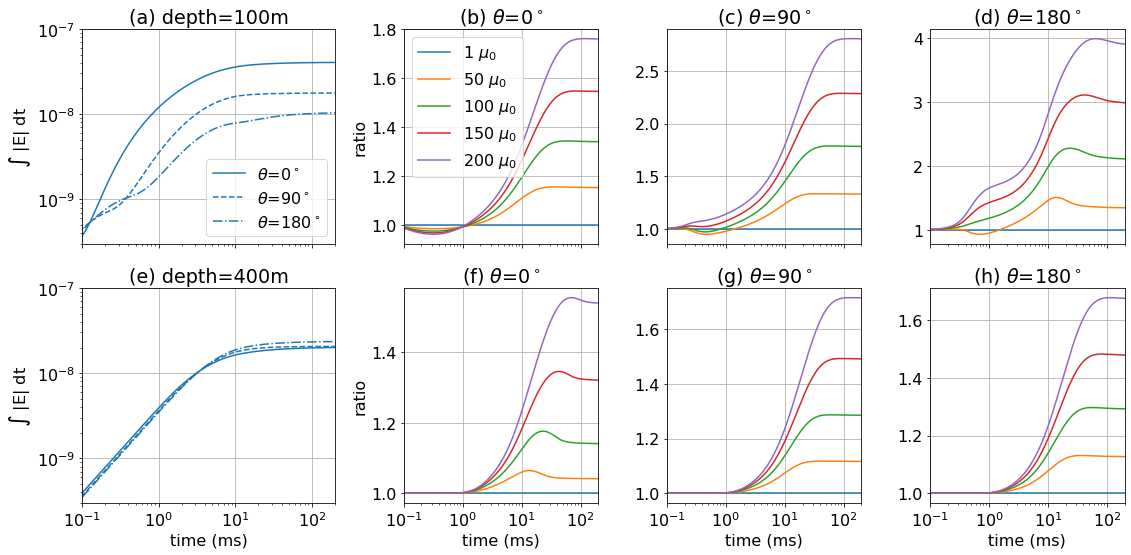

In [53]:
test_depth_inds = np.r_[0, 2]
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1.3, 1, 1, 1]})

primary_key = "casing_1"
focus_key = None
linestyles = ["-", "--", "-."]
for k, key in enumerate(list(e_integrated.keys())[1:]):
    val = e_integrated[key] / e_integrated[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        theta_label = (mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            
            if key == primary_key or key == focus_key:
                ax[j, 0].loglog(
                    times*1e3, e_integrated[key][i, jj, :], color= f"C{k}", 
                    ls=linestyles[i], label=f"$\\theta$={theta_label:1.0f}$^\circ$" if key==primary_key else None
                )
                ax[j, 0].set_title(f"({ascii_lowercase[j*4]}) depth={np.mean(depthi):1.0f}m")
            ax[j, i+1].semilogx(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i+1].set_title(
                f"({ascii_lowercase[(j*4+1)+i]}) $\\theta$={theta_label:1.0f}$^\circ$"
            )
                    
for a in ax.flatten():              
    a.grid("both")
            
ax[0, 0].set_xlim([1e-1, 2e2])

for a in ax[-1, :].flatten():
    a.set_xlabel("time (ms)")

for a in ax[:, 0]:
    a.set_ylim([3e-10, 1e-7])
    a.set_ylabel("$\int$ |E| dt")

for a in ax[:, 1]:
    a.set_ylabel("ratio")

for a in ax[:, 1:].flatten():
    tmp = a.get_ylim()
    # a.set_ylim([0, tmp[1]])

ax[0, 1].legend()
ax[0, 0].legend()

plt.tight_layout()
            
# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/excitation-time-integrated", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/excitation-time-integrated", dpi=dpi_low, bbox_inches="tight")

In [ ]:
test_depth_inds = np.r_[0, 2]
primary_key = "casing_1"
fig, ax = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=False)
for k, key in enumerate(list(e_avg.keys())[1:]):
    val = e_avg[key] - e_avg[primary_key]
    label = f"{key.split('_')[-1]} $\mu_0$"
    for i, thetai in enumerate(test_theta):
        for j, jj in enumerate(test_depth_inds):
            depthi = test_depths[jj]
            ax[j, i].loglog(times*1e3, val[i, jj, :], color=f"C{k}", label=label)
            ax[j, i].set_title(
                f"$\\theta$={(mesh.cell_centers_y[thetai] - mesh.hy[0]/2 )*180/np.pi:1.0f}$^\circ$, depth={np.mean(depthi):1.0f}m"
            )
            ax[j, i].grid("both")
            ax[j, i].set_xlim([1e-1, 2e2])
            ax[j, i].set_ylim([1e-9, 3e-5])

for a in ax[2, :].flatten():
    a.set_xlabel("time (ms)")
    
ax[0, 0].legend()

plt.tight_layout()
            

In [55]:
plot_spatial = {}

for model_type in ["casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    tmp = {}
    for ti in time_inds:
        primary = discretize.utils.mkvc(fields[f"casing_1"][:,'e', ti])
        total = discretize.utils.mkvc(fields[f"{model_type}"][:,'e', ti])
        tmp[ti] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/np.abs(primary) * 100
        }
    plot_spatial[model_type] = tmp

In [56]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", color=None, label=None, invert_axes=False):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end] 
                
            if np.all(yvals <= 0):
                if invert_axes is True:
                    getattr(ax, plot_type)(np.abs(yvals), xvals, "--", color=color)
                else: 
                    getattr(ax, plot_type)(xvals, np.abs(yvals), "--", color=color)
            else: 
                if invert_axes is True: 
                    getattr(ax, plot_type)(yvals, xvals, "-", color=color, label=label)
                else:
                    getattr(ax, plot_type)(xvals, yvals, "-", color=color, label=label)
                label=None
        return ax

In [57]:
theta_loc=5

In [58]:
plot_spatial["casing_1"].keys()

dict_keys([0, 53, 109, 152, 169, 197, 249])

In [59]:
def plot_spatial_data(plot_spatial, ax, tind, xlim=None, ylim=None, percent_lim=None, labels=True, legend=True, plot_diff=True):
    zloc = -csz/2
    face_inds_plotting = np.hstack([
        ((mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
         (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))),
        np.zeros(mesh.n_faces_y, dtype=bool), np.zeros(mesh.n_faces_z, dtype=bool)
    ])
    
    for i, key in enumerate(list(plot_spatial.keys())):
        val = plot_spatial[key][tind]
        legend = f"{key.split('_')[-1]} $\mu_0$"
        plot_pos_neg_log(mesh.nodes_x[1:], val["total"][face_inds_plotting].squeeze(), ax[0], "semilogy", label=legend, color=f"C{i}") 
        if plot_diff: 
            plot_pos_neg_log(mesh.nodes_x[1:], val["difference"][face_inds_plotting], ax[1], "semilogy", label=legend, color=f"C{i}")
            plot_pos_neg_log(mesh.nodes_x[1:], val["percent"][face_inds_plotting], ax[2], "semilogy", label=legend, color=f"C{i}")

    
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(percent_lim)
    
    if labels is True: 
        ax[0].set_ylabel("Amplitude (V/m)")
        ax[1].set_ylabel("Difference (V/m)")
        ax[2].set_ylabel("Difference (%)")
    
    if legend is True:
        ax[0].legend()
    ax[2].set_xlabel("x (m)")

    for a in ax.flatten():
        a.grid("both", alpha=0.6)
        a.set_xlim(xlim)
    
    return ax



/tmp/ipykernel_42894/3648330709.py:4: FutureWarning: CylindricalMesh.vectorCCy has been deprecated, please use CylindricalMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  ((mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) &


array([<AxesSubplot:ylabel='Amplitude (V/m)'>,
       <AxesSubplot:ylabel='Difference (V/m)'>,
       <AxesSubplot:xlabel='x (m)', ylabel='Difference (%)'>],
      dtype=object)

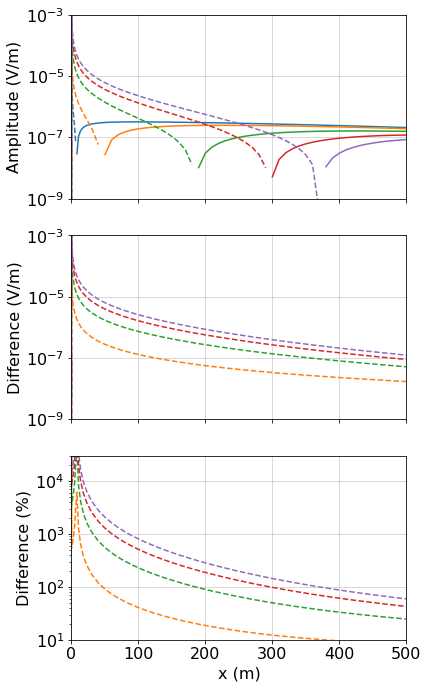

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(6, 11.5), sharex=True)
time_inds_plot = [197]

xlim = np.r_[0, 500]
ylim = np.r_[1e-9, 1e-3]
ylim_percent = np.r_[1e1, 3e4]

plot_spatial_data(plot_spatial, ax, time_inds_plot[0], xlim=xlim, ylim=ylim, percent_lim=ylim_percent)

/tmp/ipykernel_42894/3930917527.py:20: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  theta_shift=0.5*mesh.hy[0],


Text(0.5, 1.0, '(c) difference')

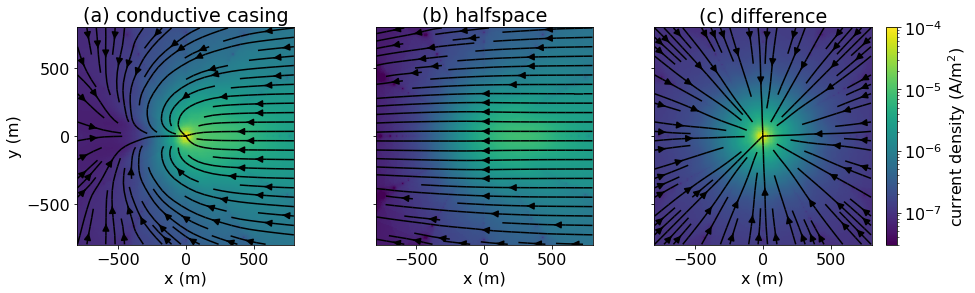

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={"hspace":0.09,"wspace":0.01})
key = "casing_1"
f = fields[key]
xlim=800*np.r_[-1, 1]

zind = 118
clim = np.r_[3e-8, 1e-4]

stream_opts={"color":"k", "density":0.8, "arrowsize":1.4, "linewidth":1.5}
for a, key, primsec in zip(ax, ["casing_1", "halfspace", "casing_1"], ["total", "total", "secondary"]): 
    out = casing_sim.view.plot_depth_slice(
        fields[key],
        view="j",
        primary_fields=fields["halfspace"],
        prim_sec=primsec,
        time_ind=time_inds[2],
        xlim=xlim,
        ylim=xlim,
        z_ind=zind, 
        theta_shift=0.5*mesh.hy[0],
        ax=a, 
        clim=clim,
        show_cb=False,
        k=40,
        # component="xz",
        stream_opts=stream_opts
    )
    a.set_title("")
    a.set_aspect(1)
    a.set_xlabel("x (m)")
    
    if a == ax[0]:
        a.set_ylabel("y (m)")
    else:
        a.set_ylabel("")
        a.set_yticklabels("")
    
cb = plt.colorbar(out[0], ax=ax[-1]) 
cb.set_label("current density (A/m$^2$)")

ax[0].set_title("(a) conductive casing")
ax[1].set_title("(b) halfspace")
ax[2].set_title("(c) difference")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/currents-depth-slice", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/currents-depth-slice", dpi=dpi_low, bbox_inches="tight")

In [67]:
def add_circle(ax, radius, color="k", ls="-"):
    x = np.linspace(-radius, radius, 100)
    top = np.sqrt(radius**2 - x**2)
    ax.plot(x, top, color=color, ls=ls)
    ax.plot(x, -top, color=color, ls=ls)

/tmp/ipykernel_42894/3270044935.py:13: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  theta_shift=0.5*mesh.hy[0],


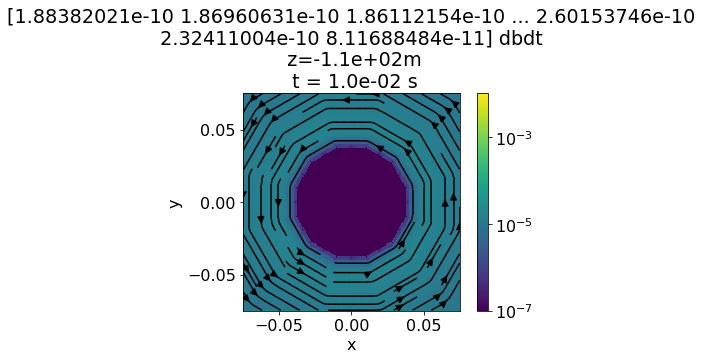

In [68]:
fig, ax = plt.subplots(1, 1)
xlim = 0.075 * np.r_[-1, 1]
zind = 97
out = casing_sim.view.plot_depth_slice(
    fields["casing_1"],
    view="dbdt",
    primary_fields=fields["casing_1"],
    prim_sec=total,
    time_ind=time_inds[4],
    xlim=xlim,
    ylim=xlim,
    z_ind=zind, 
    theta_shift=0.5*mesh.hy[0],
    ax=ax, 
    clim=np.r_[1e-7, 1e-2],
    show_cb=False,
    k=3,
    # component="y",
    stream_opts=stream_opts
    )
# ax.set_title("")
ax.set_aspect(1)
plt.colorbar(out[0], ax=ax)

In [69]:
tinds_plot = [109, 169]
times[tinds_plot]*1e3

array([ 0.99, 10.02])

In [70]:
xlocs = np.r_[60]
mesh.vectorNx[xlocs]

/tmp/ipykernel_42894/300462054.py:2: FutureWarning: CylindricalMesh.vectorNx has been deprecated, please use CylindricalMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  mesh.vectorNx[xlocs]


array([100.])

In [71]:
zloc = -csz/2
theta_loc = 6

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
    )[0]
    print(mesh.faces_x[face_inds[i], :])

[100.           3.40339204  -2.5       ]


/tmp/ipykernel_42894/1472696077.py:8: FutureWarning: CylindricalMesh.vectorNx has been deprecated, please use CylindricalMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
/tmp/ipykernel_42894/1472696077.py:9: FutureWarning: CylindricalMesh.vectorCCy has been deprecated, please use CylindricalMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) &


In [72]:
plot_timeseries = {}

for model_type in ["halfspace", "casing_1", "casing_50", "casing_100", "casing_150", "casing_200"]:
    tmp = {}
    for fi in face_inds:
        tmp[fi] = (discretize.utils.mkvc(fields[f"{model_type}"][:,'e', :][fi, :]))
    plot_timeseries[model_type] = tmp

In [73]:
def plot_time_data(val, ax, color_ind=None, xlim=None, ylim=None, percent_lim=None, labels=True, legend=True):
    legend = f"{key.split('_')[-1]} $\mu_0$"
    ax[0].loglog(times*1e3, np.abs(val["total"]), label=legend, color=f"C{color_ind}")
    ax[1].loglog(times*1e3, np.abs(val["difference"]), color=f"C{color_ind}")
    ax[2].loglog(times*1e3, np.abs(val["percent"]), color=f"C{color_ind}")

    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    ax[2].set_ylim(percent_lim)

    if labels is True: 
        ax[0].set_ylabel("electric field Amplitude (V/m)")
        ax[1].set_ylabel("Difference (V/m)")
        ax[2].set_ylabel("Difference (%)")
    
    if legend is True: 
        ax[0].legend(loc=3)
    ax[2].set_xlabel("time (ms)")
    for a in ax.flatten(): 
        a.grid("both", alpha=0.6)
        a.set_xlim(xlim)

    
    return ax

In [74]:
from matplotlib.lines import Line2D

In [75]:
rcParams["font.size"]=14

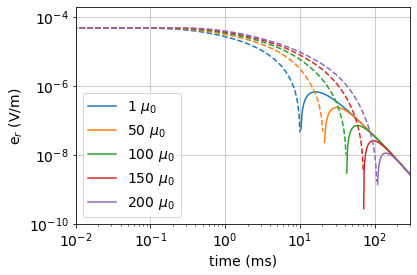

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4)) 
fi = 0

for i, k in enumerate(list(plot_timeseries.keys())[1:]):
    val = plot_timeseries[k][face_inds[fi]]
    legend = f"{k.split('_')[-1]} $\mu_0$"
    plot_pos_neg_log(times*1e3, val, ax, plot_type="loglog", color=f"C{i}", label=legend)

# lines = [Line2D([0], [0], color=f"C{i}") for i in range(len(mur_casing))]
ax.grid("both", alpha=0.8)
ax.set_xlim(np.r_[1e-2, 3e2])
ax.set_ylim(np.r_[1e-10, 2e-4])
ax.set_xlabel("time (ms)")
ax.legend()

ax.set_ylabel("e$_r$ (V/m)")

if save_figures:
    fig.savefig(f"{fig_dir_high}/e-fields-tdem.png", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/e-fields-tdem.png", dpi=dpi_low, bbox_inches="tight")

In [81]:
tinds_plot = [0, 109] #, 197]
print(times[tinds_plot] * 1e3)

[0.   0.99]


In [82]:
theta_ind=0
tind_plot=time_inds[2]

def plot_cross_section_field(
    key, field, time_ind=0, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    prime_sec="total", primary_key=None, 
    log_scale=False, eps=1e-15, vmin=None, clim=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)

    if field in ["b", "h", "dbdt", "dhdt"]: 
        ave = mesh.average_edge_to_cell_vector
    elif field in ["e", "j"]:
        ave = mesh.average_face_to_cell_vector
        
    field_plot = ave * fields[key][:, field, time_ind]
    
    if prime_sec in ["secondary", "percent", "primary"]:
        if primary_key is None: 
            primary_key = get_primary_key(key)
        primary = ave * fields[primary_key][:, field, time_ind]
        if prime_sec == "primary": 
            field_plot = primary
        else: 
            field_plot = field_plot - primary
            if prime_sec == "percent":
                field_plot = dfield_plot / np.abs(primary + eps) * 100

    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind, :]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror, :]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    # plot x,z vector
    fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
    fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

    sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

    vmax = clim.max() if clim is not None else None
    if log_scale is True: 
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else: 
        norm = Normalize(0, vmax)
    out = mesh2d.plot_image(
        fieldxz, v_type="CCv", view="vec", ax=ax[0],
        range_x=xlim, range_y=zlim,
        sample_grid=sample_grid,
        mirror=True, mirror_data=fieldxz_mirror,
        pcolor_opts={"norm":norm},
        stream_threshold=vmin,
    )
    plt.colorbar(out[0], ax=ax[0])

    
    pcolor_optsy = {"cmap":"Spectral_r"}
    linthresh = vmin if vmin is not None else eps
    
    if clim is None: 
        # vmin, vmax = np.max(np.abs(
        #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
        # ))*np.r_[-1, 1]
        vmin, vmax = norm.vmax*np.r_[-1, 1]
    else: 
        vmin = np.min(clim)
        vmax = np.max(clim)
        
    if log_scale is True:
        pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
    else: 
        pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    
    out2 = mesh2d.plot_image(
        field_components["y"]["data"], ax=ax[1],
        mirror=True, mirror_data=field_components["y"]["mirror"],
        range_x=xlim, range_y=zlim, 
        pcolor_opts=pcolor_optsy
    )
    plt.colorbar(out2[0], ax=ax[1])
    return ax

In [83]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    137,
    # 152,
    169,
    # 171,
    # 175,
    # 179,
    # 182,
    # 187,
    197,
] 
print(times[time_inds] * 1e3)

[ 0.     0.099  0.99   3.02  10.02  30.32 ]


In [84]:
fields.keys()

dict_keys(['halfspace', 'casing_1', 'casing_50', 'casing_100', 'casing_150', 'casing_200'])

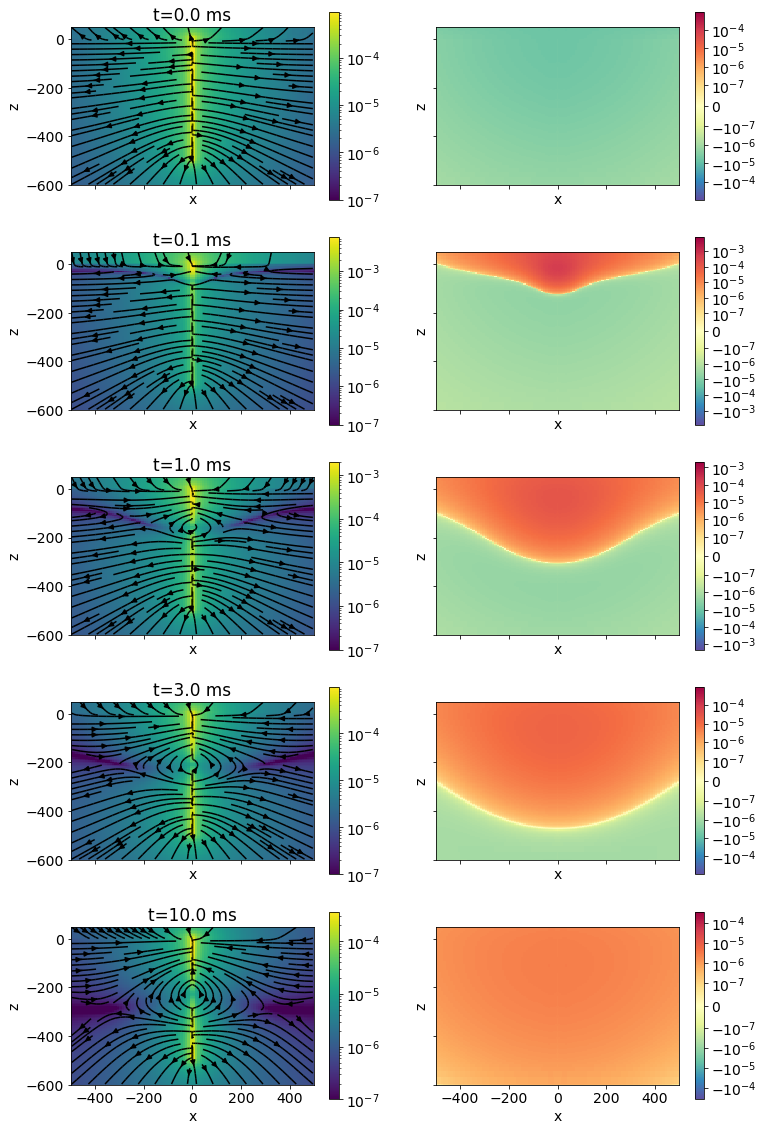

In [85]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "e", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="total", 
        log_scale=True,
        # clim=1e-3*np.r_[-1, 1],
        vmin=1e-7
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

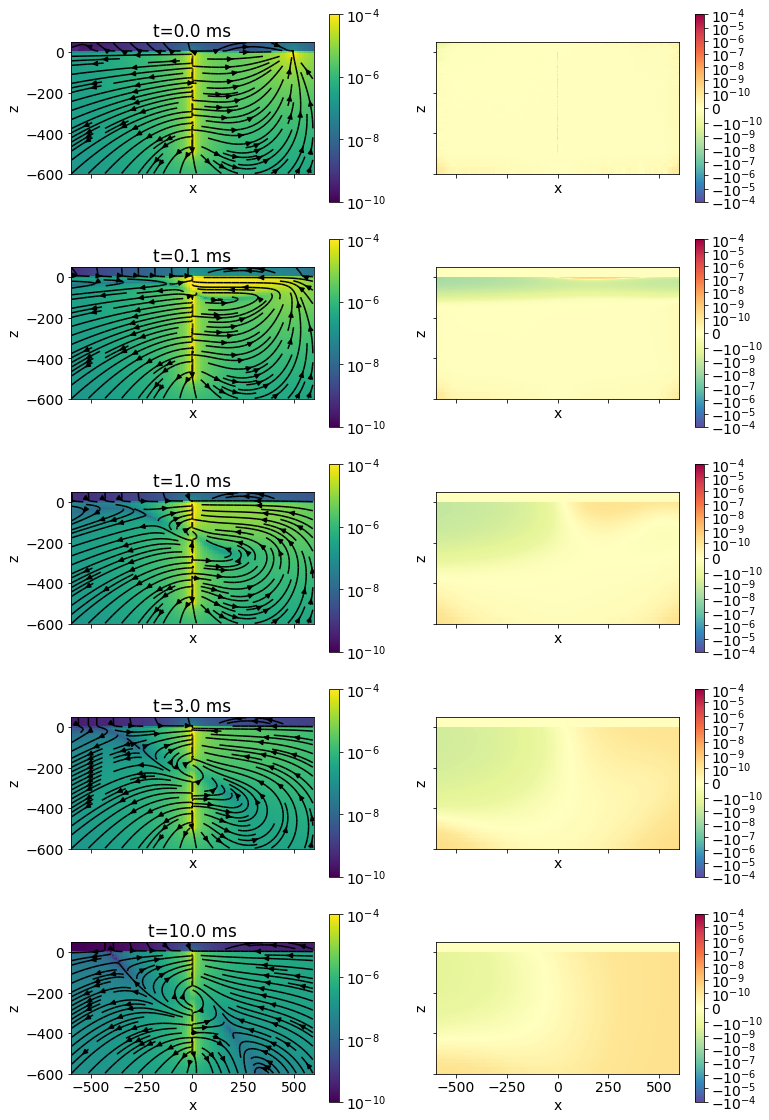

In [86]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

# key = "permeable_only_5000000.0"
# primary_key = "halfspace"


for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "j", time_ind=ti, theta_ind=0, ax=ax[i,:], 
        xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="total",
        clim=1e-4*np.r_[-1, 1],
        log_scale=True,
        vmin=1e-10
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

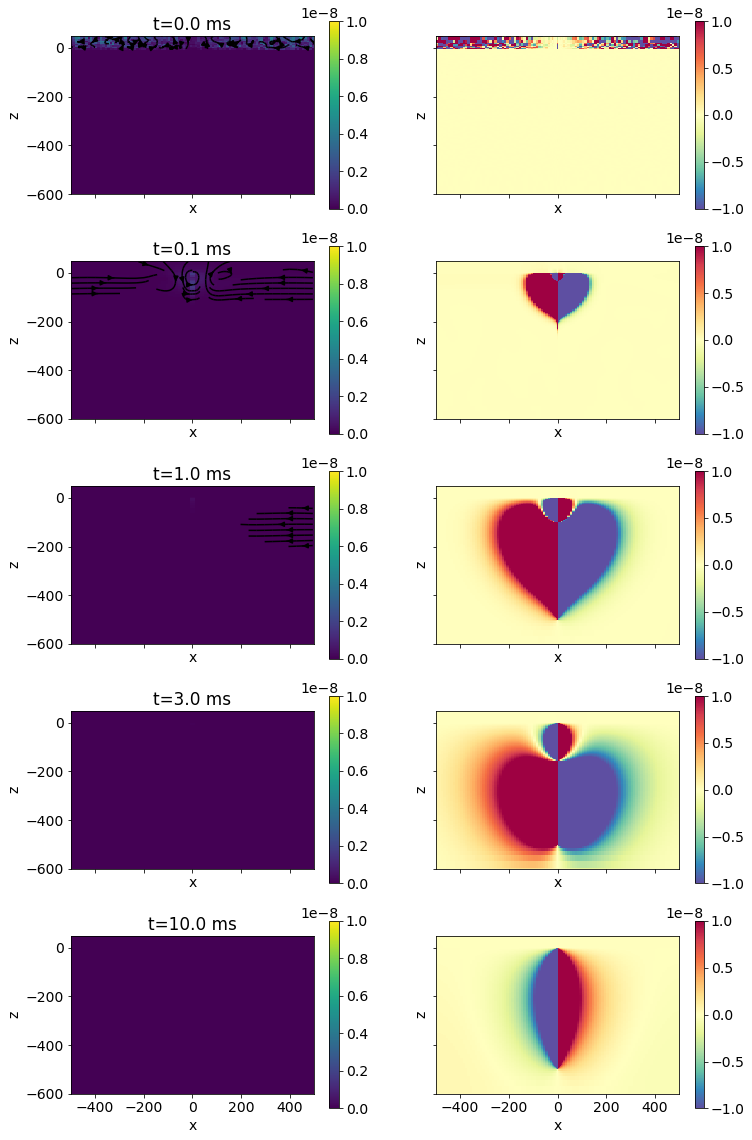

In [87]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

# key = "casing_1"
# primary_key = None #"mu_1_target_1e-01"

key = "casing_200"
primary_key = "casing_1" 

for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "dbdt", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="secondary", 
        # log_scale=True,
        vmin=1e-11,
        clim=1e-8*np.r_[-1, 1]
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

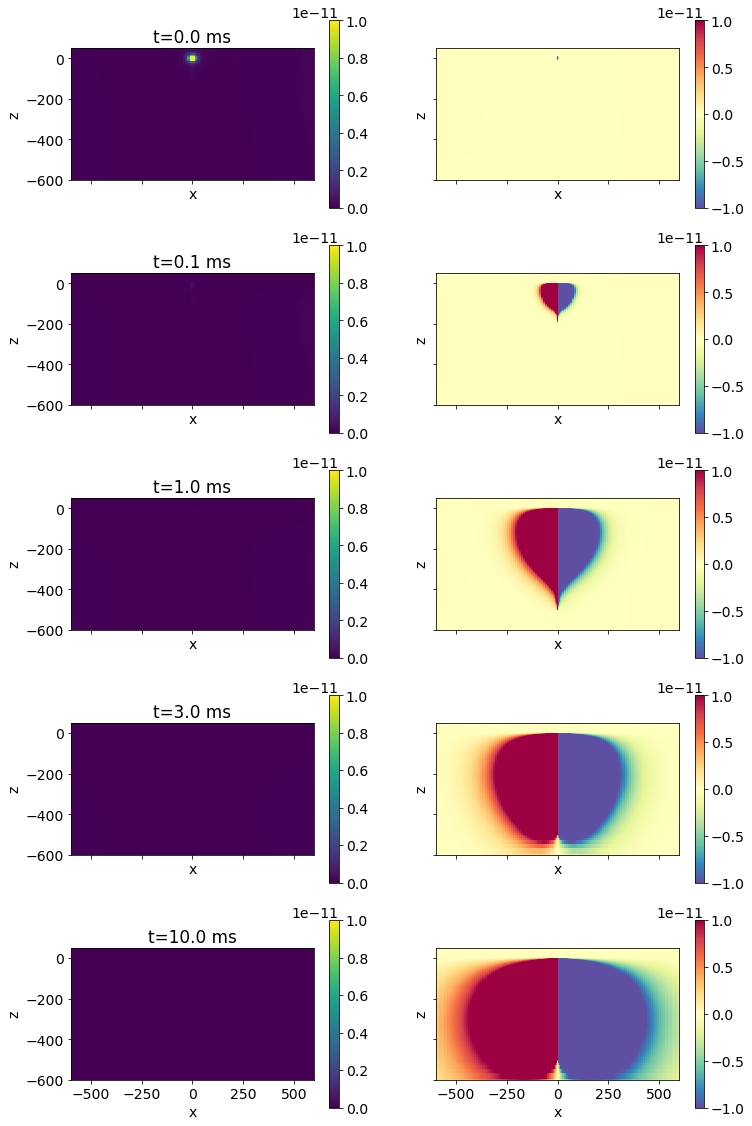

In [88]:
tinds_plot = time_inds[:-1] 

fig, ax = plt.subplots(
    len(tinds_plot), 2, figsize=(12,4*len(tinds_plot)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

# key = "permeable_only_5000000.0"
# primary_key = "halfspace"

for i, ti in enumerate(tinds_plot):
    plot_cross_section_field(
        key, "b", time_ind=ti, theta_ind=3, ax=ax[i,:], 
        xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        prime_sec="secondary", 
        # log_scale=True,
        vmin=1e-10,
        clim=1e-11*np.r_[-1, 1]
    )
    ax[i, 0].set_title(f"t={times[ti]*1e3:1.1f} ms")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [140]:
f = fields["casing_150"]
sim = f.simulation

In [141]:
b = f[:, "b", :]
j = f[:, "j", :]

In [142]:
curl_b = mesh.edge_curl * b

In [143]:
not_hanging_faces = np.hstack([
    ~getattr(mesh, f"_ishanging_faces_{coord}_bool") for coord in ["x", "y", "z"]
])

In [144]:
not_hanging_edges = np.hstack([
    ~getattr(mesh, f"_ishanging_edges_{coord}_bool") for coord in ["x", "y", "z"]
])

In [145]:
ave_fz2ey = discretize.utils.kron3(
    discretize.utils.speye(mesh.shape_faces_z[2]),
    discretize.utils.speye(mesh.shape_faces_z[1]),
    discretize.utils.av_extrap(mesh.shape_faces_z[0]),
)[~mesh._ishanging_edges_y_bool, :] #* mesh._deflation_matrix("Ey", as_ones=True).T

ave_fx2ey = discretize.utils.kron3(
    discretize.utils.av_extrap(mesh.shape_faces_x[2]),
    discretize.utils.speye(mesh.shape_faces_x[1]),
    discretize.utils.speye(mesh.shape_faces_x[0]),
) 

In [146]:
# ln_mu_term = ( 
#     -(mesh._face_divergence_stencil.T * np.log(sim.mu / mu_0))[not_hanging_faces]
# )
ln_mu_term = ( discretize.utils.sdiag(mesh.area * (mesh.average_cell_to_face * (1./mesh.vol))) *  
    -(mesh._face_divergence_stencil.T * (np.log(sim.mu / mu_0)))[not_hanging_faces]
)

ln_mu_r = ln_mu_term[:mesh.n_faces_x]
# ln_mu_t = ln_mu_term[mesh.n_cells:2*mesh.n_cells]
ln_mu_z = ln_mu_term[np.sum(mesh.n_faces_per_direction[:2]):]

by = b[mesh.n_edges_x:np.sum(mesh.n_edges_per_direction[:2]), :]
cross_x = - discretize.utils.sdiag(ave_fz2ey * ln_mu_z) * by
# cross_y = discretize.utils.sdiag(ln_mu_z) * b_r - discretize.utils.sdiag(ln_mu_r) * b_z
cross_z = discretize.utils.sdiag(ave_fx2ey * ln_mu_r) * by



/tmp/ipykernel_42894/2095559952.py:4: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  ln_mu_term = ( discretize.utils.sdiag(mesh.area * (mesh.average_cell_to_face * (1./mesh.vol))) *
/tmp/ipykernel_42894/2095559952.py:4: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  ln_mu_term = ( discretize.utils.sdiag(mesh.area * (mesh.average_cell_to_face * (1./mesh.vol))) *


In [147]:
b.shape

(612141, 317)

In [148]:

# lnmur_cross_b = np.vstack([cross_x, cross_y, cross_z])
lnmu_cross_b = np.vstack([
    mesh.average_edge_y_to_cell * cross_x,
    np.zeros((mesh.n_cells, len(times))), 
    mesh.average_edge_y_to_cell * cross_z
])

In [149]:
curl_b_cc = mesh.average_face_to_cell_vector * curl_b

In [150]:
mu_j = (
    discretize.utils.sdiag(np.kron(np.ones(3), sim.mu)) * 
    mesh.average_face_to_cell_vector * j
)

In [152]:
np.max(curl_b_cc[:, ti] - mu_j[:, ti] - lnmu_cross_b[:, ti])

6.189433940895483e-06

In [153]:
MuI = discretize.utils.sdiag(np.kron(np.ones(3), 1./sim.mu))

In [154]:
def plot_cell_centered_vector(
    field_plot, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    real_or_imag="real", 
    log_scale=False, eps=1e-15, vmin=None, clim=None,
    component="both", show_colorbar=True,
    stream_opts=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)
    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    if component == "both" or component == "xz": 
        if component == "both":
            ax_xz = ax[0]
        else:
            ax_xz = ax
        # plot x,z vector
        fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
        fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

        vmax = clim.max() if clim is not None else None
        if log_scale is True: 
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else: 
            norm = Normalize(0, vmax)
        out = mesh2d.plot_image(
            fieldxz, v_type="CCv", view="vec", ax=ax_xz,
            range_x=xlim, range_y=zlim,
            sample_grid=sample_grid,
            mirror=True, mirror_data=fieldxz_mirror,
            pcolor_opts={"norm":norm},
            stream_threshold=vmin,
            stream_opts=stream_opts
        )
        if show_colorbar is True: 
            plt.colorbar(out[0], ax=ax_xz)


        pcolor_optsy = {"cmap":"Spectral_r"}
        linthresh = vmin if vmin is not None else eps

        if clim is None: 
            # vmin, vmax = np.max(np.abs(
            #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
            # ))*np.r_[-1, 1]
            vmin, vmax = norm.vmax*np.r_[-1, 1]
        else: 
            vmin = np.min(clim)
            vmax = np.max(clim)

        if log_scale is True:
            pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
        else: 
            pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    if component == "both" or component == "y": 
        if component == "both":
            ax_y = ax[1]
        else: 
            ax_y = ax
        out2 = mesh2d.plot_image(
            field_components["y"]["data"], ax=ax_y,
            mirror=True, mirror_data=field_components["y"]["mirror"],
            range_x=xlim, range_y=zlim, 
            pcolor_opts=pcolor_optsy
        )
        if show_colorbar is True: 
            plt.colorbar(out2[0], ax=ax_y)
    return out

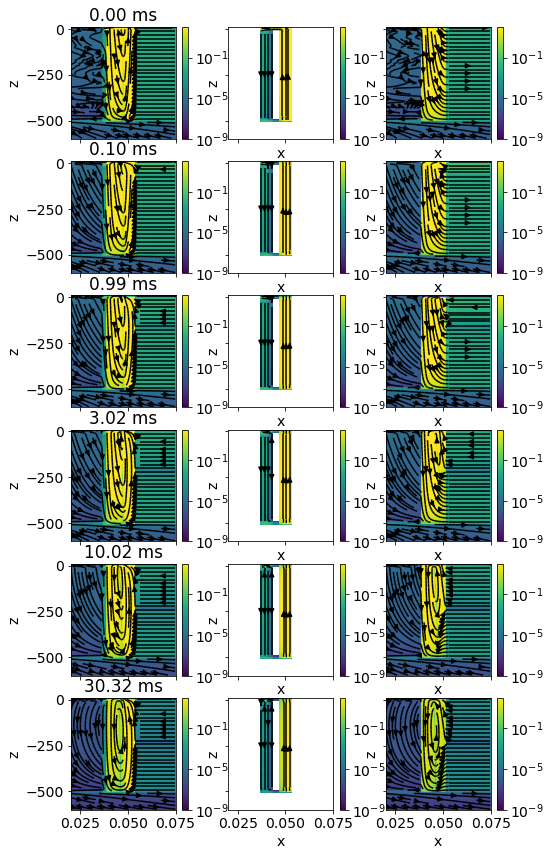

In [155]:
fig, ax = plt.subplots(
    len(time_inds), 3, figsize=(8, (len(time_inds))*2.4),
    sharex=True, sharey=True
)

xlim = np.r_[0.02, 0.075]
zlim = np.r_[-600, 10]
clim = np.r_[1e-9, 1e2]

for i, ti in enumerate(time_inds):
    plot_cell_centered_vector(
        MuI * curl_b_cc[:, ti], 
        theta_ind=3, ax=ax[i, 0], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        # MuI * (curl_b_cc[:, ti] - mu_j[:, ti]),
        MuI * lnmu_cross_b[:, ti], 
        theta_ind=3, ax=ax[i, 1], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        MuI * mu_j[:, ti], 
        theta_ind=3, ax=ax[i, 2], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    ax[i, 0].set_title(f"{times[ti]*1e3:1.2f} ms")
    ax[i, 0].set_xlabel("")

Text(0.5, 1.0, '(c) $\\nabla \\times \\vec{b}$')

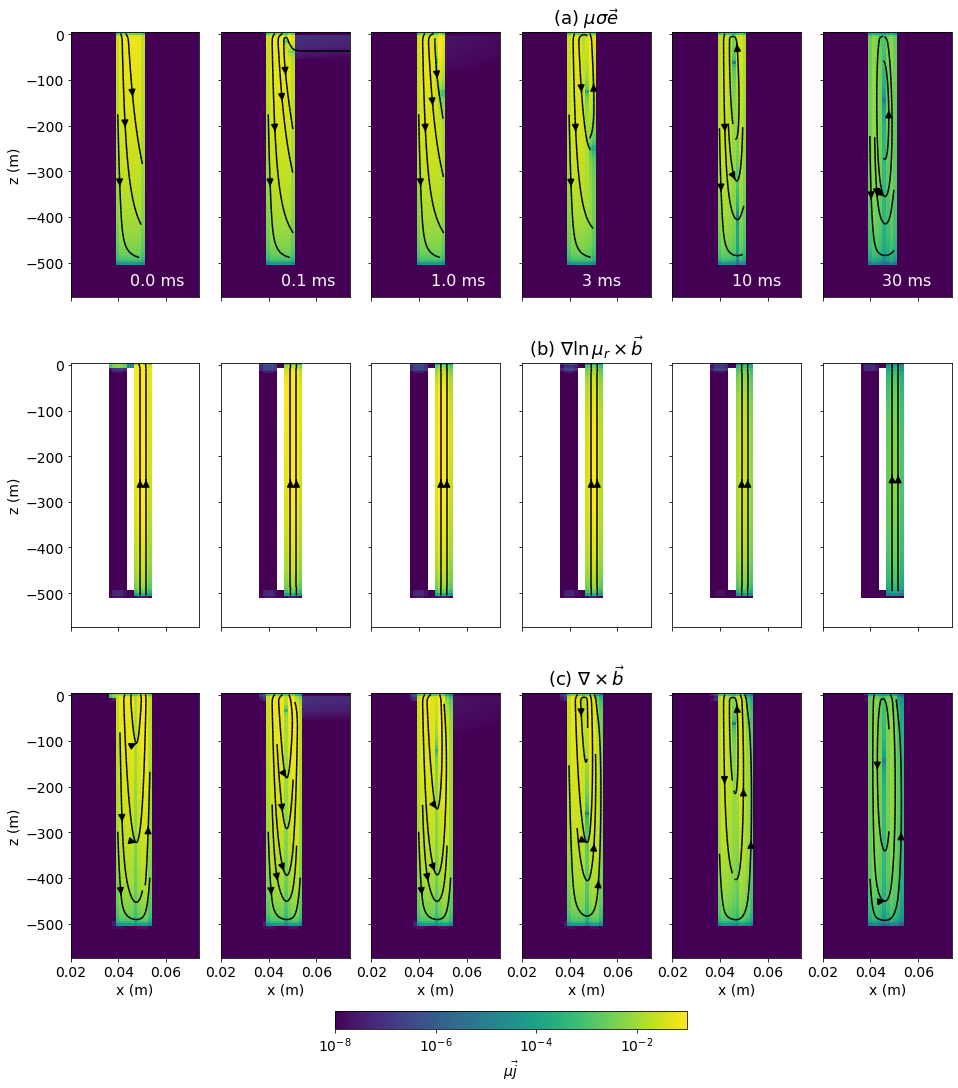

In [157]:
fig, ax = plt.subplots(
    3, len(time_inds),
    figsize=(len(time_inds)*2.2, 15),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.02}
)

xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-8, 1e-1]

stream_opts= {"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}

for j, ti in enumerate(time_inds):
    
    plot_cell_centered_vector(
        mu_j[:, ti], 
        theta_ind=3, ax=ax[0, j], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=False,
        stream_opts=stream_opts
    )
    
    plot_cell_centered_vector(
        # (curl_b_cc[:, ti] - mu_j[:, ti]),
        lnmu_cross_b[:, ti], 
        theta_ind=3, ax=ax[1, j], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=False,
        stream_opts=stream_opts
    )
    
    out = plot_cell_centered_vector(
        curl_b_cc[:, ti], 
        theta_ind=3, ax=ax[2, j], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=False,
        stream_opts=stream_opts
    )
    for i, a in enumerate(ax[:, j].flatten()):
        a.set_title("")
        a.set_xlim([0.02, 0.074])
        if j > 0: 
            a.set_ylabel("")
        else: 
            a.set_ylabel("z (m)")
        if i < 2:
            a.set_xlabel("")
        else:
            a.set_xlabel("x (m)")

    if times[ti] < 2e-3: 
        ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=16)
    else: 
        ax[0, j].text(0.045, -550, f"{times[ti]*1e3:1.0f} ms", color="w", fontsize=16)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("$\mu \\vec{j}$")

ax[0, 3].set_title("(a) $\mu \sigma \\vec{e}$", fontsize=18, pad=8)
ax[1, 3].set_title("(b) $\\nabla \ln \mu_r \\times \\vec{b}$", fontsize=18, pad=8)
ax[2, 3].set_title("(c) $\\nabla \\times \\vec{b}$", fontsize=18, pad=8)

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/magnetization-currents-casing", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/magnetization-currents-casing", dpi=dpi_low, bbox_inches="tight")

In [158]:
fields.keys()

dict_keys(['halfspace', 'casing_1', 'casing_50', 'casing_100', 'casing_150', 'casing_200'])

In [159]:
z_ind = 98
mesh.nodes_z[z_ind]

-104.99999999999869

In [160]:
np.kron([1, 2, 3], [1, 1])

array([1, 1, 2, 2, 3, 3])

In [161]:
def get_dedt(fields, ti):
    dhdt = fields[:, "dhdt", ti].squeeze()
    djdt = mesh.edge_curl * dhdt
    dedt = discretize.utils.sdiag(
        np.kron(np.ones(3), fields.simulation.rho)
    )* mesh.average_face_to_cell_vector * djdt
    return dedt

In [162]:
def get_curl_curl_e(fields, ti):
    e = fields[:, "e", ti].squeeze()
    return mesh.average_face_to_cell_vector * mesh.edge_curl * mesh.edge_curl.T * e

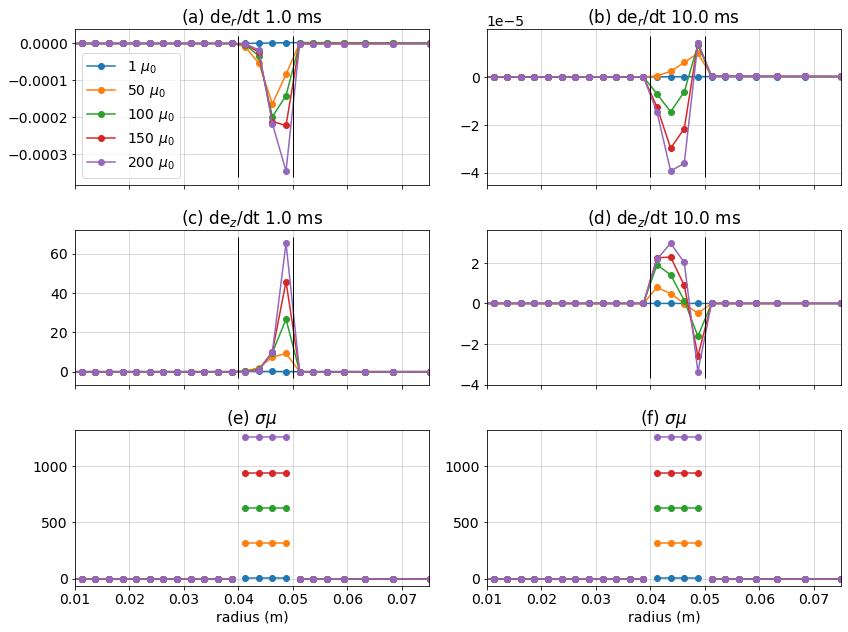

In [163]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 98
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(3, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 9))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

# inds_plot_er = np.where(
#     (mesh.faces_x[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_x[:, 2] == mesh.cell_centers_z[z_ind])
# )[0] 

# inds_plot_ez = np.where(
#     (mesh.faces_z[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_z[:, 2] == mesh.nodes_z[z_ind])
# )[0] + np.sum(mesh.n_faces_per_direction[:2])

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)
inds_plot_er = np.where(inds_mu_plot)[0]
inds_plot_ez = np.where(inds_mu_plot)[0] + mesh.n_cells * 2

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        dedt = get_dedt(fields_plot, ti)
        sigmu = (fields_plot.simulation.sigma * fields_plot.simulation.mu)[inds_mu_plot]
        dedt_r = sigmu * dedt[inds_plot_er]
        dedt_z = sigmu * dedt[inds_plot_ez]
        
        ax[0, j].plot(mesh.cell_centers_x, dedt_r, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) de$_r$/dt {times[ti] *1e3:1.1f} ms")
        
        ax[1, j].plot(mesh.cell_centers_x, dedt_z, "-o", label=label)
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) de$_z$/dt {times[ti] *1e3:1.1f} ms")
        
        
        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
            ax[2, j].plot(x, sigmu[inds], "-o", color=f"C{i}", label=label) 
        ax[2, j].set_title(f"({ascii_lowercase[j+4]}) $\sigma \mu$")
        
    ax[0, 0].set_xlim(xlim)

for a in ax.flatten():
    a.grid("both", alpha=0.6)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()


for a in ax[2, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/induction-term", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/induction-term", dpi=dpi_low, bbox_inches="tight")

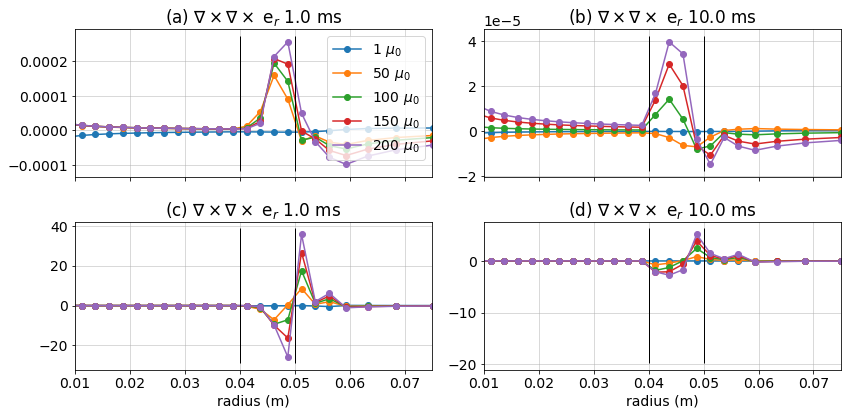

In [164]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 98
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(2, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 6))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

# inds_plot_er = np.where(
#     (mesh.faces_x[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_x[:, 2] == mesh.cell_centers_z[z_ind])
# )[0] 

# inds_plot_ez = np.where(
#     (mesh.faces_z[:, 1] == mesh.cell_centers_y[theta_ind]) & 
#     (mesh.faces_z[:, 2] == mesh.nodes_z[z_ind])
# )[0] + np.sum(mesh.n_faces_per_direction[:2])

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)
inds_plot_er = np.where(inds_mu_plot)[0]
inds_plot_ez = np.where(inds_mu_plot)[0] + mesh.n_cells * 2

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        curlcurle = get_curl_curl_e(fields_plot, ti)
        sigmu = (fields_plot.simulation.sigma * fields_plot.simulation.mu)[inds_mu_plot]
        curlcurle_r = curlcurle[inds_plot_er]
        curlcurle_z = curlcurle[inds_plot_ez]
        
        ax[0, j].plot(mesh.cell_centers_x, curlcurle_r, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) $\\nabla \\times \\nabla \\times$ e$_r$ {times[ti] *1e3:1.1f} ms")
        
        ax[1, j].plot(mesh.cell_centers_x, curlcurle_z, "-o", label=label)
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) $\\nabla \\times \\nabla \\times$ e$_r$ {times[ti] *1e3:1.1f} ms")
        
        
        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
        
    ax[0, 0].set_xlim(xlim)

for a in ax.flatten():
    a.grid("both", alpha=0.6)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()


for a in ax[-1, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

if save_figures: 
    fig.savefig(f"{fig_dir_high}/induction-term", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/induction-term", dpi=dpi_low, bbox_inches="tight")

In [165]:
mesh.nodes_z[99]

-99.99999999999869

/tmp/ipykernel_42894/3381974792.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2, j].set_yticklabels(["", "", "", "0", "", ""])


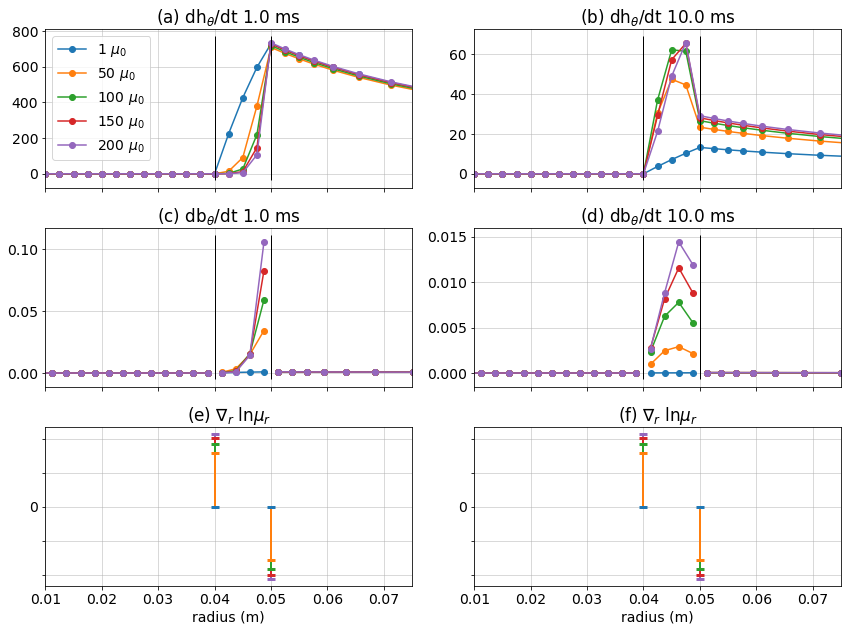

In [166]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 99
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(3, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 9))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

inds_plot = np.where(
    (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.edges_y[:, 2] == mesh.nodes_z[z_ind])
)[0] + mesh.n_edges_x 

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)

avx = discretize.utils.av(len(mesh.nodes_x[1:]))

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        # b = fields_plot[src_plot, "b"][inds_plot]
        dhdt = fields_plot[:, "dhdt", ti][inds_plot].squeeze()
        dhdtc = avx * np.hstack([np.r_[0], dhdt])
        dbdtc = fields_plot.simulation.mu[inds_mu_plot] * dhdtc
        # bc = discretize.utils.av(mesh.nodes

        ax[0, j].plot(mesh.nodes_x[1:], dhdt, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) dh$_\\theta$/dt {times[ti] *1e3:1.1f} ms")

        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
            ax[1, j].plot(x, dbdtc[inds].real, "-o", color=f"C{i}", label=label)
        
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) db$_\\theta$/dt {times[ti] *1e3:1.1f} ms")
    
    ax[0, 0].set_xlim(xlim)

for j in range(2): 
    for i, mur in enumerate(np.flipud(mur_plot)):
        divlogmur = np.log(mur)
        for x, posneg in zip([casing_a, casing_b], [1, -1]):
            ax[2, j].plot(np.r_[x, x], np.r_[0, posneg]*divlogmur, lw=2, color=f"C{4-i}")
            ax[2, j].plot(x, posneg*divlogmur, "_", color=f"C{4-i}", ms=8, markeredgewidth=3)
        ax[2, j].set_yticklabels(["", "", "", "0", "", ""])
        ax[2, j].set_title(f"({ascii_lowercase[4+j]}) $\\nabla_r$ ln$\mu_r$")

for a in ax.flatten():
    a.grid("both", alpha=0.6)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()


for a in ax[2, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/magnetization-term", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig( f"{fig_dir_low}/magnetization-term", dpi=dpi_low, bbox_inches="tight")

/tmp/ipykernel_42894/1786893089.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2, j].set_yticklabels(["", "", "", "0", "", ""])


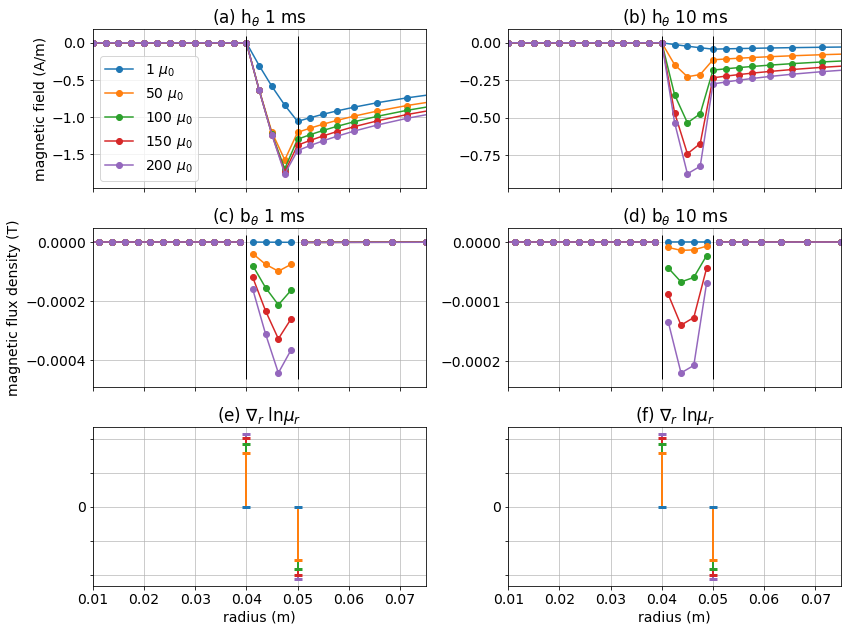

In [168]:

xlim = np.r_[0.01, 0.075]
theta_ind = 3
z_ind = 99
mur_plot = mur_casing
l_plot = 500
tinds_dbdt_plot = np.r_[109, 169]

fig, ax = plt.subplots(3, len(tinds_dbdt_plot), sharex=True, figsize=(len(tinds_dbdt_plot)*6, 9))

plot_keys = [f"casing_{mur}" for mur in mur_casing]

inds_plot = np.where(
    (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.edges_y[:, 2] == mesh.nodes_z[z_ind])
)[0] + mesh.n_edges_x 

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)

avx = discretize.utils.av(len(mesh.nodes_x[1:]))

for i, mur in enumerate(mur_plot):
    key = f"casing_{mur}"
    label = f"{mur} $\mu_0$"
    
    fields_plot=fields[key]
    
    for j, ti in enumerate(tinds_dbdt_plot): 
        # b = fields_plot[src_plot, "b"][inds_plot]
        h = fields_plot[:, "h", ti][inds_plot].squeeze()
        hc = avx * np.hstack([np.r_[0], h])
        bc = fields_plot.simulation.mu[inds_mu_plot] * h
        # bc = discretize.utils.av(mesh.nodes

        ax[0, j].plot(mesh.nodes_x[1:], h, "-o", label=label)
        ax[0, j].set_title(f"({ascii_lowercase[j]}) h$_\\theta$ {times[ti] *1e3:1.0f} ms")

        for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
            xplt = mesh.cell_centers_x
            inds = (xplt > start) & (xplt <= end)
            x = xplt[inds]
            ax[1, j].plot(x, bc[inds].real, "-o", color=f"C{i}", label=label)
        
        ax[1, j].set_title(f"({ascii_lowercase[j+2]}) b$_\\theta$ {times[ti] *1e3:1.0f} ms")
    
    ax[0, 0].set_xlim(xlim)

for j in range(2): 
    for i, mur in enumerate(np.flipud(mur_plot)):
        divlogmur = np.log(mur)
        for x, posneg in zip([casing_a, casing_b], [1, -1]):
            ax[2, j].plot(np.r_[x, x], np.r_[0, posneg]*divlogmur, lw=2, color=f"C{4-i}")
            ax[2, j].plot(x, posneg*divlogmur, "_", color=f"C{4-i}", ms=8, markeredgewidth=3)
        ax[2, j].set_yticklabels(["", "", "", "0", "", ""])
        ax[2, j].set_title(f"({ascii_lowercase[4+j]}) $\\nabla_r$ ln$\mu_r$")

for a in ax.flatten():
    a.grid("both", alpha=0.8)
    
for a in ax[:2, :].flatten():   
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()

ax[0, 0].set_ylabel("magnetic field (A/m)")
ax[1, 0].set_ylabel("magnetic flux density (T)")

for a in ax[2, :].flatten():
    a.set_xlabel("radius (m)")

plt.tight_layout()

if save_figures: 
    fig.savefig(f"{fig_dir_high}/magnetization-term", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/magnetization-term", dpi=dpi_low, bbox_inches="tight")